In [1]:
#importing neccessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('Data/train_avg_age.csv')
df_test = pd.read_csv('Data/test_avg_age.csv')
df_val = pd.read_csv('Data/val_avg_age.csv')
df_train.shape, df_test.shape, df_val.shape

((170760, 14), (62096, 14), (42691, 14))

In [3]:
y = df_train.country_destination
X = df_train.drop(['country_destination'], axis=1)

In [4]:
weights = [0.0]*12
for i in range(len(y)):
    weights[y[i]] += 1
weights = np.array(weights)

weights = weights.sum()/ weights
weights = np.log(weights)

sample_weights = [weights[y[_]] for _ in range(len(y))]

sample_weights

[0.541700685822729,
 0.541700685822729,
 1.227196596886953,
 1.227196596886953,
 0.541700685822729,
 0.541700685822729,
 0.541700685822729,
 1.227196596886953,
 0.541700685822729,
 0.541700685822729,
 0.541700685822729,
 1.227196596886953,
 3.7412952976692075,
 1.227196596886953,
 0.541700685822729,
 1.227196596886953,
 0.541700685822729,
 0.541700685822729,
 0.541700685822729,
 0.541700685822729,
 0.541700685822729,
 0.541700685822729,
 1.227196596886953,
 1.227196596886953,
 0.541700685822729,
 0.541700685822729,
 0.541700685822729,
 3.7412952976692075,
 0.541700685822729,
 1.227196596886953,
 0.541700685822729,
 1.227196596886953,
 1.227196596886953,
 1.227196596886953,
 1.227196596886953,
 1.227196596886953,
 0.541700685822729,
 0.541700685822729,
 0.541700685822729,
 1.227196596886953,
 1.227196596886953,
 0.541700685822729,
 1.227196596886953,
 1.227196596886953,
 0.541700685822729,
 1.227196596886953,
 0.541700685822729,
 0.541700685822729,
 0.541700685822729,
 0.541700685822729

In [5]:
xgb = XGBClassifier(max_depth=10, learning_rate=0.2, n_estimators=100,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=43, sample_weight=sample_weights)
xgb.fit(X, y)

[17:19:23] WARNING: ../src/learner.cc:541: 
Parameters: { sample_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:19:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob...
                             0.541700685822729, 0.541700685822729,
                             0.541700685822729, 0.541700685822729,
                             0.541700685822729, 0.541700685822729,
                             1.227196596886953, 1.227196596886953,
                             0.541700685822729, 0.541700685822729,
                             0.541700685822729, 3.7412952976692075,
                             0.541700685822729, 1.227196596886953, ...],
              scale_pos_weight=None, seed=43, subsample=0.5,
       

In [6]:
import pickle
filename = 'XGB_001.sav'
pickle.dump(xgb, open(filename, 'wb'))

In [7]:
y_val = df_val.country_destination
X_val = df_val.drop(['country_destination'], axis=1)

In [8]:
y_pred = xgb.predict_proba(X_val)

In [9]:
y_pred

array([[2.00261939e-02, 2.45332695e-03, 2.18225271e-03, ...,
        2.65321275e-03, 2.57805077e-04, 7.98217416e-01],
       [3.30111012e-02, 5.42059541e-03, 5.04798954e-03, ...,
        1.20821055e-02, 1.28845742e-03, 6.72543943e-01],
       [9.05638468e-03, 1.69474841e-03, 2.04086932e-03, ...,
        3.87550145e-03, 1.83341792e-03, 5.06783247e-01],
       ...,
       [1.43757574e-02, 4.19939915e-03, 4.17099101e-04, ...,
        7.23245263e-04, 1.02375646e-03, 9.03924346e-01],
       [2.76842136e-02, 1.29876919e-02, 1.33134553e-03, ...,
        4.21958324e-03, 9.91858076e-04, 7.63413131e-01],
       [3.93220149e-02, 8.43673386e-03, 3.20702069e-03, ...,
        6.18069293e-03, 2.99687916e-03, 7.72080600e-01]], dtype=float32)

<AxesSubplot:xlabel='country_destination', ylabel='count'>

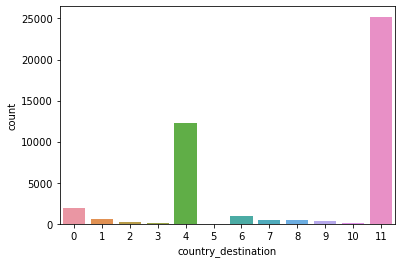

In [10]:
sns.countplot(y_val)

In [11]:
from sklearn.metrics import ndcg_score, dcg_score
import math

def NDCG_Score(y_val, y_pred):
  NDCG_score = 0.0
  for i in range(len(y_val)):
    res = y_val[i]
    array_prob = np.argsort(y_pred[i])[-5:][::-1]
    index = np.where(array_prob == res)
    
    if index[0].size != 0:
      NDCG_score += 1.0/math.log(index[0][0]+2, 2)
  NDCG_score = NDCG_score*1.0/len(y_val)
  return NDCG_score

In [12]:
print(NDCG_Score(y_val, y_pred))

0.8260832973722801


In [13]:
df_test

,affiliate_channel,affiliate_provider,age,dac_month,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,tfa_month,id
0,2.0,4.0,35.0,7,6.0,30.0,8.0,1.0,6.0,1.0,0.0,1.0,7,5uwns89zht
1,2.0,4.0,37.0,7,6.0,30.0,8.0,0.0,6.0,1.0,0.0,0.0,7,jtl0dijy2j
2,2.0,4.0,37.0,7,0.0,8.0,6.0,0.0,6.0,2.0,0.0,0.0,7,xx0ulgorjt
3,2.0,4.0,37.0,7,0.0,22.0,6.0,0.0,6.0,2.0,0.0,0.0,7,6c6puo6ix0
4,2.0,4.0,37.0,7,6.0,43.0,3.0,0.0,6.0,2.0,0.0,0.0,7,czqhjk3yfe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62091,2.0,4.0,31.0,9,6.0,22.0,6.0,0.0,6.0,2.0,0.0,0.0,9,cv0na2lf5a
62092,2.0,4.0,37.0,9,6.0,0.0,0.0,0.0,16.0,0.0,15.0,0.0,9,zp8xfonng8
62093,2.0,4.0,37.0,9,0.0,17.0,6.0,0.0,4.0,2.0,0.0,0.0,9,fa6260ziny
62094,5.0,8.0,37.0,9,3.0,43.0,3.0,0.0,6.0,2.0,0.0,0.0,9,87k0fy4ugm


In [14]:
t = {'3':'AU',
  '9':'CA',
  '2':'DE',
  '8':'ES',
  '6':'FR',
  '7':'GB',
  '1':'IT',
  '11':'NDF',
  '10':'NL',
  '5':'PT',
  '4':'US',
  '0':'other'}

In [15]:
id_test = df_test.id
X_test = df_test.drop(['id'], axis=1)
y_pred = xgb.predict_proba(X_test)
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += (np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.country = sub.country.map(t)
sub.to_csv('sub.csv',index=False)

<AxesSubplot:xlabel='country_destination', ylabel='count'>

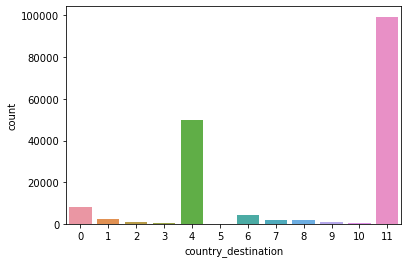

In [16]:
sns.countplot(df_train.country_destination)

In [18]:
print("ndcg_score on validation set: 0.8260832973722801, kaggle_private_score: 0.86423")

ndcg_score on validation set: 0.8260832973722801, kaggle_private_score: 0.86423
